In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### dataset & augmentation

In [5]:
# 定义SimCLR的数据增强
class SimCLRTransform:
    def __init__(self, size=28):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor(),
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)

# 加载Fashion MNIST数据集
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=SimCLRTransform(),
    download=True
)

# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, num_workers=8, drop_last=True, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, drop_last=True, pin_memory=True)

In [6]:
batch_xs, batch_y = next(iter(train_loader))

In [7]:
batch_xs[0].shape, batch_xs[1].shape, batch_y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 28, 28]), torch.Size([128]))

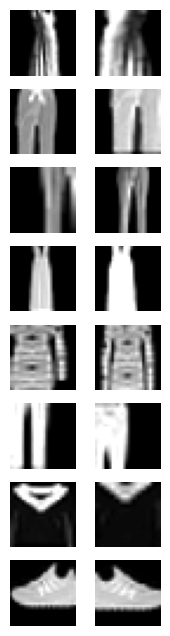

In [8]:
# 可视化前两对增强图像
def imshow(img, ax):
    img = img / 2 + 0.5  # 反归一化
    npimg = img.numpy()
    # ax.imshow(np.transpose(npimg, (1, 2, 0)), )
    ax.imshow(npimg.squeeze(), cmap='gray')  # 将单通道图像显示为灰度图

fig, axs = plt.subplots(8, 2, figsize=(2, 8))  # 创建一个2x2的图像展示框架
# 展示增强后的图像对
for i in range(8):
    imshow(batch_xs[0][i], axs[i, 0])  # 显示第一张图像
    # axs[i, 0].set_title('Transformed Image 1')
    axs[i, 0].axis('off')

    imshow(batch_xs[1][i], axs[i, 1])  # 显示第二张图像
    # axs[i, 1].set_title('Transformed Image 2')
    axs[i, 1].axis('off')

plt.show()

### model

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, feature_dim=128):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # 7x7 -> 1x1
        )
        self.fc = nn.Linear(128, feature_dim)

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=128, hidden_dim=128, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class SimCLR(nn.Module):
    def __init__(self, encoder, projection_head):
        super(SimCLR, self).__init__()
        self.encoder = encoder
        self.projection_head = projection_head

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection_head(h)
        return F.normalize(z, dim=1)

### infoNCE loss

In [10]:
import torch
import torch.nn.functional as F

# unsupervised
def info_nce_loss(z_i, z_j, temperature=0.5):
    N = z_i.size(0)
    z = torch.cat([z_i, z_j], dim=0)  # 2N x D

    # 计算相似度矩阵 (2N x 2N)
    similarity_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)

    # 创建标签：前N个样本的正样本在后N个位置，后N个样本的正样本在前N个位置
    # [512, ...., 1023, 0, ..., 512]
    labels = torch.cat([torch.arange(N, 2*N), torch.arange(0, N)], dim=0).to(z.device)

    # 生成掩码，去除自相似性
    mask = torch.eye(2 * N, dtype=torch.bool).to(z.device)
    similarity_matrix = similarity_matrix / temperature
    similarity_matrix = similarity_matrix.masked_fill(mask, -9e15)

    # 计算交叉熵损失
    loss = F.cross_entropy(similarity_matrix, labels)

    return loss

### training

In [11]:
from tqdm.notebook import tqdm

In [12]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型
encoder = Encoder()
projection_head = ProjectionHead()
model = SimCLR(encoder, projection_head).to(device)

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 训练参数
epochs = 200
model.train()

for epoch in tqdm(range(epochs)):
    total_loss = 0
    # unsupervised settings
    for (x_i, x_j), _ in train_loader:
        x_i = x_i.to(device, non_blocking=True)
        x_j = x_j.to(device, non_blocking=True)

        z_i = model(x_i)
        z_j = model(x_j)

        loss = info_nce_loss(z_i, z_j)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    # 1024 => 5.9
    if epoch % 40 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {avg_loss:.4f}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [0/200], Loss: 4.4921


### visualization

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
# 加载测试集
test_transform = transforms.ToTensor()
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=test_transform,
    download=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=4
)

In [ ]:
model.eval()
features = []
labels = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        h = model.encoder(x)
        features.append(h.cpu())
        labels.append(y)

features = torch.cat(features, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

In [ ]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(features[:,0], features[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization of SimCLR Features on Fashion MNIST")
plt.show()

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

In [ ]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(features_tsne[:,0], features_tsne[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE Visualization of SimCLR Features on Fashion MNIST")
plt.show()


In [ ]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(features_pca[:,0], features_pca[:,1], c=labels, cmap='tab10', alpha=0.6)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("PCA Visualization of SimCLR Features on Fashion MNIST")
plt.show()